**Importing Required Libraries**

In [61]:
#visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

#libraries for importing mnist dataset
from torchvision import datasets, transforms
import torch.utils.data

#libraries for loading dataset and 80:20 split is mentioned in the problem, so concatinating the dataset and splitting it.
from torch.utils.data import DataLoader,ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler

#JAX libraries
import jax
from jax import random
import jax.numpy as jnp
from jax import jit, value_and_grad
from jax.experimental import optimizers

**Helper Functions**

In [62]:
sns.set(context='poster', style='white',
        font='sans-serif', font_scale=1, color_codes=True, rc=None)

def plot_mnist_examples(train_loader):
    # Plot some MNIST example samples
    for batch_idx, (data, target) in enumerate(train_loader):
        images = jnp.asarray(data[:5, ...]).reshape(5, 28, 28)
        target = jnp.asarray(target[:5, ...])
        break
    fig, axs = plt.subplots(1, 5, figsize=(10, 5))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(images[i,...], cmap="Greys")
        ax.set_title("Label: {}".format(target[i]), fontsize=30)
        ax.set_axis_off()
    fig.tight_layout()


def plot_mnist_performance(train_loss, sup_title="Loss Curve"):
    """ Visualize the learning performance of a classifier on MNIST """
    fig, axs = plt.subplots()
    axs.plot(train_loss)
    axs.set_xlabel("Iterations")
    axs.set_ylabel("Batch Loss")
    axs.set_title("Training Loss")

**Downloading and Loading the dataset**

In [63]:
#Initializing the parameters
test_split=0.2
shuffle_dataset = True
temp_seed= 18
batch_size=100

#downloading the mnist training data (consists of 60000 examples)
train_dataset_temp = datasets.MNIST(root='train_mnist', train=True, download=True,transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))#normalization is used as the input is in rgb format, we need to convert it to greyscale format which is done using normalization.
                   ]))

#downloading the mnist testing data (consists of 10000 examples)
test_dataset_temp = datasets.MNIST(root='test_mnist', train=False, download=True, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
dataset = ConcatDataset([train_dataset_temp, test_dataset_temp])#concatinating both training and testing datasets
print(type(train_dataset_temp))#used for debugging purposes
print(type(dataset))#used for debugging purposes

#splitting the data randomly in the ratio 80:20
dataset_size = len(dataset)
indices = jnp.asarray(range(dataset_size))
split = int(jnp.floor(test_split * dataset_size))
if shuffle_dataset :
    indices=jax.random.permutation(random.PRNGKey(temp_seed),indices,independent=True)
indices=indices.tolist()
train_indices, test_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = list(SubsetRandomSampler(train_indices))
test_sampler = list(SubsetRandomSampler(test_indices))
print(type(train_sampler))#used for debugging purposes
print(len(train_sampler))
train_loader = DataLoader(dataset,batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
print(type(train_loader))#used for debugging purposes

<class 'torchvision.datasets.mnist.MNIST'>
<class 'torch.utils.data.dataset.ConcatDataset'>
<class 'list'>
56000
<class 'torch.utils.data.dataloader.DataLoader'>


**Visualising some examples in the training data**

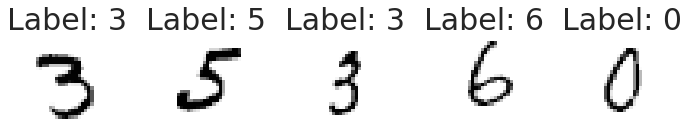

In [64]:
#displays first 5 examples
plot_mnist_examples(train_loader)

**Creating and training the neural networks**

In [65]:
def initialize_nn(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys = random.split(key, len(sizes))
    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_layer(m, n, key, scale=0.01):
        w_key, b_key = random.split(key)
        return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

#creating 4 layers i.e.,
#1st layer-input layer of size 784
#2nd layer of size 512 neurons
#3rd layer of size 512 neurons
#4th layer-output layer of size 10 (number of classes)
layer_sizes = [784, 512, 512, 10] 
# Return a list of tuples of layer weights
key = random.PRNGKey(1)#key is generated for assigning random weights before the 1st epoch, without jax np.random() is used for generating random weights.
params = initialize_nn(layer_sizes, key)

**Pytree Visualisation**
pytree visualisation is used to identify the structure of the neural network. It can be used for a cross-verification purpose i.e., whether the neural network architecture that we initiated is correct or not. tree_map function available in jax library can be used to represent pytree structure.

In [66]:
tree_structure=jax.tree_map(lambda x: x.shape, params)
print(tree_structure)
# Let's see how many leaves they have:
for level in tree_structure:
  layers = jax.tree_leaves(level)
  print(f"{repr(level)} level has {len(layers)} layers: {layers}")

[((256, 784), (256,)), ((256, 256), (256,)), ((10, 256), (10,))]
((256, 784), (256,)) level has 3 layers: [256, 784, 256]
((256, 256), (256,)) level has 3 layers: [256, 256, 256]
((10, 256), (10,)) level has 3 layers: [10, 256, 10]


**Creating Sigmoid Activation function**

In [67]:
def Sigmoid(x):
    #sigmoid function (f(x)) = 1/(1+ e^(-x))
    return 1/(1 + jnp.exp(-x))
    
def Sigmoid_layer(params, x):
    #Simple Sigmoid layer for single sample
    return Sigmoid(jnp.dot(params[0], x) + params[1])

**Creating forward pass of the neural network**

In [68]:
from jax.scipy.special import logsumexp
from jax import vmap
def forward_pass(params, in_array):
    #Computing the forward pass for each example individually 
    activations = in_array
    # Loop over the Sigmoid hidden layers
    for w, b in params[:-1]:
        activations = Sigmoid_layer([w, b], activations)
    # Perform final trafo to logits
    final_w, final_b = params[-1]
    logits = jnp.dot(final_w, activations) + final_b
    return logits - logsumexp(logits)
# Make a batched version of the `predict` function
batch_forward = vmap(forward_pass, in_axes=(None, 0), out_axes=0)

**Creating loss and accuracy function for performance evaluation**

In [69]:
num_classes=10
def one_hot(x, k, dtype=jnp.float32):
    #Creating a one-hot encoding of x of size k
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

def loss(params, in_arrays, targets):
    #Computing the multi-class cross-entropy loss
    preds = batch_forward(params, in_arrays)
    return -jnp.sum(preds * targets)

def accuracy(params, data_loader):
    #Computing the accuracy for a provided dataloader
    acc_total = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        images = jnp.array(data).reshape(data.size(0), 28*28)
        targets = one_hot(jnp.array(target), num_classes)
        target_class = jnp.argmax(targets, axis=1)
        predicted_class = jnp.argmax(batch_forward(params, images), axis=1)
        acc_total += jnp.sum(predicted_class == target_class)
    return acc_total/len(data_loader.dataset)

**Creating update function for backward propagation calculation**

In [70]:
@jit #jit(just in time) is a compiler used for faster execution
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x, y)#value_and_grad is used for the differentiation calculation when backpropagating
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

# Defining an optimizer in Jax
step_size = 0.001
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)
num_epochs = 10

**Testing the created neural network architecture on mnist dataset**

In [71]:
def run_mnist_training_loop(num_epochs, opt_state):
    #Implements a learning loop over epochs. 
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Get initial accuracy after random initialization
    train_acc = accuracy(params, train_loader)
    test_acc = accuracy(params, test_loader)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)
    print("Epoch no - Train Accuracy - Test Accuracy for batch size:"+str(batch_size)+" for architecture:"+str(layer_sizes))
    # Loop over the training epochs
    for epoch in range(num_epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            # Flatten the image into 784 vectors for the NN
            x = jnp.array(data).reshape(data.size(0), 28*28)
            y = one_hot(jnp.array(target), num_classes)
            params, opt_state, loss = update(params, x, y, opt_state)
            train_loss.append(loss)
        train_acc = accuracy(params, train_loader)
        test_acc = accuracy(params, test_loader)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        print("Epoch {} - Train A: {:0.3f} - Test A: {:0.3f}".format(epoch+1, train_acc, test_acc))
    return train_loss, log_acc_train, log_acc_test
train_loss, train_log, test_log = run_mnist_training_loop(num_epochs,opt_state)

Epoch no - Train Accuracy - Test Accuracy for batch size:1000 for architecture:[784, 256, 256, 10]
Epoch 1 - Train A: 0.685 - Test A: 0.171
Epoch 2 - Train A: 0.736 - Test A: 0.183
Epoch 3 - Train A: 0.750 - Test A: 0.186
Epoch 4 - Train A: 0.759 - Test A: 0.188
Epoch 5 - Train A: 0.765 - Test A: 0.190
Epoch 6 - Train A: 0.769 - Test A: 0.191
Epoch 7 - Train A: 0.773 - Test A: 0.192
Epoch 8 - Train A: 0.775 - Test A: 0.192
Epoch 9 - Train A: 0.778 - Test A: 0.192
Epoch 10 - Train A: 0.780 - Test A: 0.193


**Plotting loss v/s iterations**

560


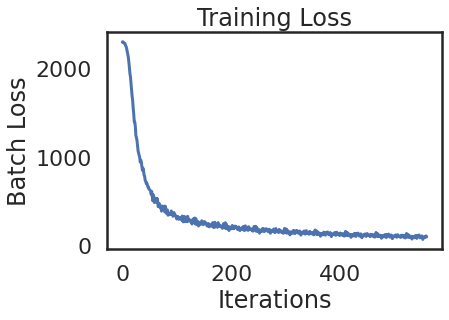

In [72]:
# Plot the loss curve over iterations
print(len(train_loss))
plot_mnist_performance(train_loss, "MNIST NN Performance")